# Tutorial on Percolation Analysis with GEMDAT

Welcome to this tutorial on percolation analysis using the Gemdat Python library for Molecular Dynamics (MD) simulations. Gemdat is a powerful tool built on top of [Pymatgen](https://pymatgen.org/), which makes it straightforward to integrate into your existing Pymatgen-based workflows for materials analysis.

This tutorial demonstrates how to use Gemdat to perform percolation analysis on MD simulation data. We will cover:
- Analyzing environment-specific activation energies.
- Visualizing activation energies via violin plots.
- Performing percolation analysis by randomizing non-diffusing atoms.
- Computing optimal energy paths and comparing multiple pathfinding algorithms.

## How to Cite

When you use **GEMDAT code** in academic work **[please cite](https://github.com/GEMDAT-repos/GEMDAT/blob/main/CITATION.cff)**:

Azizi, V., Smeets, S., Lavrinenko, A. K., Ciarella, S., Famprikis, T., Landgraf, V., & Vasileiadis, A. GEMDAT (Version 1.6.0) [Computer software]. https://github.com/GEMDAT-repos/GEMDAT, doi: 10.5281/zenodo.8401669

##### 1. Data Loading

In [2]:
# Import necessary libraries
from gemdat import Trajectory
from pymatgen.core import Structure, Lattice, DummySpecie
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import os

# This block will suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define the path to workshop folder
os.chdir('path/to/workshop/folder')

# Define the path to VASP data
VASPRUN = 'data/vasprun.xml'

# Read and cache the trajectory data
trajectory = Trajectory.from_vasprun(VASPRUN, cache='data/vasprun_LSN.xml.a45e320a.cache')

Before analyzing the data, let's visualize the structure and lithium density from the AIMD trajectory. We will create a structure with lithium sites using the pymatgen library.

In [ ]:
# Create a structure for Li sites using a predefined spacegroup and lattice parameters.
sites_li = Structure.from_spacegroup(
    sg='Fm-3m',
    lattice=Lattice.cubic(5.578),
    species=['Li', 'Li'],
    coords=[[0, 0.5, 0], [0.25, 0.25, 0.25]],
    labels=['Li-oct', 'Li-tet']
)
sites_li.make_supercell((2, 2, 2))  # Expand to a supercell

# Visualize structure
fig = trajectory.to_volume().plot_3d(structure=sites_li)
fig.show()

##### 2. Extracting Jump Transitions
Here we compute transitions between the sites and extract jump events along with their activation energies. Gemdat allows you to create a graph object from jump events that helps with extracting site-specific activation energies.

In [ ]:
# Compute transitions between the Li sites for the diffusing Li specie.
transitions = trajectory.transitions_between_sites(sites=sites_li, floating_specie='Li')

# Extract jump events and convert them to a graph representation.
jumps = transitions.jumps()
jumps_graph = jumps.to_graph()

Activation energy between two specific sites can be extracted using a specific function or retrieved directly from the graph. Note that the function `activation_energy_between_sites` creates a graph from the jumps data for every separate run. Therefore, if you need to extract it for several pairs of sites, creating the graph once and accessing the activation energies from it saves calculation time.

In [ ]:
# Example: Retrieve activation energy for a jump between sites 48 and 10.
print(f'Activation energy between sites with index 48 and 10: {jumps.activation_energy_between_sites(start=48, stop=10):.2f} eV')
# Alternatively, via the graph:
print(f'Activation energy between sites with index 48 and 10: {jumps_graph.get_edge_data(48, 10)["e_act"]:.2f} eV')

##### 3. Defining Environment Distribution Functions
Next, we define the environments. Here we specify what will be considered a jump environment for our structure.

We can assign an individual jump activation energy (Ea) value to each different jump type based on local coordination and bottleneck composition. Three general types of jumps are observed through the face-centered anion arrangement in $Li_9S_3N$:
- tetrahedron(8c)-to-octahedron(4b) (tet-oct),
- octahedron(4b)-to tetrahedron(8c) (oct-tet), and
- tetrahedron(8c)-to-tetrahedron(8c) (tet-tet) jumps.

Tetrahedral sites are coordinated by 4 anions, while octahedral sites are coordinated by 6 anions. Bottlenecks in this case are defined as the shared anions of both the starting and destination sites. The schematic below shows the bottlenecks for ordered and disordered $Li_9S_3N$.

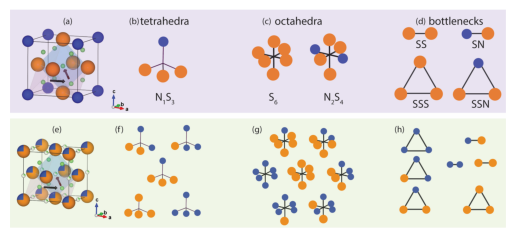

In [4]:
image = mpimg.imread('data/Environments.png')
plt.imshow(image)
plt.axis('off')
plt.show()

Before we analyze the activation energies in detail, we need to extract information about the local environment around jump events. The following functions are defined for that purpose:

- `define_env_distribution`: Constructs a supercell structure representing the non-diffusing atom environment from the AIMD trajectory.
- `jump_env`: Determines the jump type and computes a string that summarizes the local environment for two specific lithium sites.
- `define_number_per_env`: Counts how many times each local environment appears in the structure.

In [ ]:
# Define helper functions for environment analysis.

def define_env_distribution(trajectory):
    """
    Build the base environment structure from the AIMD trajectory.

    This function creates a supercell using the S sites. It then updates the structure based on
    the trajectory data for the non-diffusing species ('N' and 'S').

    Returns:
        env_structure: A Structure object representing the local environment (non-diffusing species only).
    """
    # Create the initial environment structure using a single S site.
    env_sites = Structure.from_spacegroup(
        sg='Fm-3m',
        lattice=Lattice.cubic(5.578),
        species=[DummySpecie('X')],
        coords=[[0, 0, 0]],
        labels=['4a']
    )
    env_sites.make_supercell((2, 2, 2))

    # Compute transitions from AIMD data for species 'N' and 'S'
    env_transitions = trajectory.transitions_between_sites(
        sites=env_sites,
        floating_specie=['N', 'S'],
        site_radius={'4a': 1}
    )

    # Create a structure from the transitioned sites.
    env_structure = Structure.from_sites(env_transitions.sites)

    # Update each site in the environment structure using the trajectory data.
    for idx_site, idx_specie in enumerate(env_transitions.states[0, :]):
        env_structure.replace(
            idx=idx_site,
            species=env_transitions.diff_trajectory.species[idx_specie],
            label=env_structure.labels[idx_site]
        )
    return env_structure


def jump_env(structure, start_site, end_site, env_structure, lattice=None):
    """
    Determine the jump type and construct an environment string for a jump between two sites.

    Args:
        structure (Structure): The structure containing the diffusing sites.
        start_site (int): Index of the starting site.
        end_site (int): Index of the ending site.
        env_structure (Structure): The environment structure.
        lattice (Lattice, optional): Lattice object for distance calculations.

    Returns:
        jump_type (str): Type of jump based on site labels (e.g., 'tet-tet', 'tet-oct').
        env_str (str): A string summarizing the local environment around the jump.
    """
    # Define coordination numbers for different site types.
    coordination = {'Li-tet': 4, 'Li-oct': 6}

    # Get labels for start and end sites.
    start_label = structure.labels[start_site]
    end_label = structure.labels[end_site]

    # Determine jump type from site labels.
    jump_type = start_label.split('-')[-1] + '-' + end_label.split('-')[-1]

    # Set number of nearest neighbors based on coordination.
    num_neighbors_start = coordination[start_label]
    num_neighbors_end   = coordination[end_label]

    # Use the provided lattice or extract it from the structure.
    if lattice is None:
        lattice = structure.lattice
    # Calculate full distance matrix between structure and environment sites.
    dists = lattice.get_all_distances(structure.frac_coords, env_structure.frac_coords)

    # Identify the indices of the nearest neighbors for the start and end sites.
    start_indices = np.argsort(dists[start_site, :])[:num_neighbors_start]
    end_indices   = np.argsort(dists[end_site, :])[:num_neighbors_end]

    # Create lists of tuples (label, species) for start and end neighbors.
    start_list = [(env_structure.labels[idx], env_structure.species[idx].symbol) for idx in start_indices]
    end_list   = [(env_structure.labels[idx], env_structure.species[idx].symbol) for idx in end_indices]

    # Determine the common neighbors between start and end sites.
    end_set = set(end_indices)
    common_list = [(env_structure.labels[idx], env_structure.species[idx].symbol)
                   for idx in start_indices if idx in end_set]

    # Construct sorted strings from the neighbor lists.
    start_str  = ''.join(symbol for _, symbol in sorted(start_list))
    end_str    = ''.join(symbol for _, symbol in sorted(end_list))
    common_str = ''.join(symbol for _, symbol in sorted(common_list))

    return jump_type, f"{start_str}-{end_str}--{common_str}"


def define_number_per_env(transitions, env_distribution_structure, dist_threshold=3):
    """
    Count unique occurrences of local environments for each jump.

    For every unique pair of sites (l1, l2) with a distance below a given threshold,
    compute the environment string and tally the number of occurrences.

    Args:
        transitions: Transition data object that contains site information.
        env_distribution_structure: Structure representing the local environment.
        dist_threshold (float): Maximum distance to consider for a jump.

    Returns:
        number_of_environments (defaultdict): Mapping from environment string to its count.
    """
    number_of_environments = defaultdict(int)
    dists = transitions.sites.distance_matrix  # Compute pairwise distance matrix
    # Loop only over distances below cutoff
    rows, cols = np.where(dists <= dist_threshold)
    for l1, l2 in zip(rows, cols):
        if l1 == l2:
            continue
        # Compute the environment string for the jump between l1 and l2.
        jump_type, environment = jump_env(
            transitions.sites, l1, l2,
            env_structure=env_distribution_structure,
            lattice=transitions.trajectory.get_lattice()
        )
        # Count the environment with a weighting based on jump type.
        number_of_environments[environment] += 1
    return number_of_environments

##### 4. Extracting Jump Events with Environment Details
Now, for each pair of sites between which jumps occurred, we will define an environment and associate an activation energy.

In [ ]:
# Compute the environment structure.
env_structure_cached = define_env_distribution(transitions.trajectory)

# Compute lattice distances for jumps.
lattice = trajectory.get_lattice()
dists_cached = transitions.sites.distance_matrix

# Prepare a list to hold each jump event's data.
data_list = []
# Iterate over each jump event and record its properties.
for (start, stop), n_jumps in jumps._counter().items():
    edge_data = jumps_graph.get_edge_data(start, stop)  # Retrieve activation energy info
    # Compute jump type and environment string.
    jump_type, env_str = jump_env(
        transitions.sites, start, stop,
        env_structure=env_structure_cached,
        lattice=lattice
    )
    # Append jump details as a dictionary.
    data_list.append({
        'start_site': start,
        'destination_site': stop,
        'n_jumps': n_jumps,
        'e_act': edge_data['e_act'],
        'environment': env_str,
        'dist': dists_cached[start, stop],
        'jump_type': jump_type
    })

# Create a DataFrame from the collected jump event data.
local_env_data = pd.DataFrame(data_list)
local_env_data

##### 5. Filtering and Aggregating Environment Data
Don't forget to check that all jump events are relevant. For example, in the extracted data we have some unexpected environments which we can filter based on the length of the environment string. Filtering can also be applied using a distance threshold.

After filtering, average activation energies for each jump type and local environment can be calculated.

In [ ]:
# Filter out jump events based on expected environment string lengths.
mask = (
    (local_env_data['environment'].str.len() == 13) |
    (local_env_data['environment'].str.len() == 16)
)
filtered_env_data = local_env_data[mask]

# Count the number of occurrences for each environment.
number_of_environments = define_number_per_env(transitions, env_structure_cached)

# Group the data by jump type and environment, averaging the activation energy.
filtered_env_data = filtered_env_data[['jump_type', 'environment', 'e_act']].groupby(
    by=['jump_type', 'environment'], as_index=False
).mean()

# Map the environment counts and compute relative frequency.
filtered_env_data['num_env'] = filtered_env_data['environment'].map(number_of_environments)
filtered_env_data['num_env_relative'] = 100 * filtered_env_data['num_env'] / filtered_env_data['num_env'].sum()
filtered_env_data

##### 6. Visualization: Violin Plot of Activation Energies
Next, we expand the dataset for visualization so that each jump event is represented according to its occurrence count. We then generate a violin plot to show the distribution of activation energies by jump type, where the width of the violin represents the occurrence of the jump environment in the structure.

Note that we use the seaborn library for plotting. You can install it by running `pip install seaborn`.

In [ ]:
# Expand the DataFrame: replicate each row based on the number of environment occurrences.
expanded_data = filtered_env_data.loc[filtered_env_data.index.repeat(filtered_env_data['num_env'])].copy()
expanded_data.reset_index(drop=True, inplace=True)

# Create a figure for the violin plot.
sns.set_theme(style="white", palette=None)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Generate the violin plot.
sns.violinplot(
    ax=axs,
    data=expanded_data,
    x="jump_type",
    y="e_act",
    order=['tet-tet', 'tet-oct', 'oct-tet'],
    color='b',
    density_norm='width',
    saturation=0.25,
    linewidth=0.1,
    bw_method=0.2
)

# Label the axes and set the title.
axs.set_ylabel('Jump Activation Energy (eV)')
axs.set_xlabel('Jump Type')
fig.tight_layout(pad=1.7)

# Save and display the plot.
plt.savefig('violin_plot.png', transparent=False, dpi=1200, bbox_inches='tight')
plt.show()

##### 7. Percolation Analysis
This part of the analysis does not require the AIMD trajectory and is not currently supported by GEMDAT.

The percolation analysis works as follows:

**1)** A supercell with a random distribution of environments is created.

We will perform this using a helper function that is specific to the material type you are working with.

In [ ]:
import random
from pymatgen.core import Element
from percolation_tools import add_periodic_images, analyse_percolation_through_one_supercell

def make_random_distribution(structure, inversion_rate):
    """
    Randomly distribute non-diffusing atoms (N and S) in the structure.

    Args:
        structure (Structure): The initial structure with uniform species.
        inversion_rate (float): Fraction of sites to be assigned as one species (N).

    Returns:
        structure_new (Structure): Updated structure with a random distribution.
    """
    labels_array = np.array(structure.labels)
    idx_4a = np.where(labels_array == '4a')[0]
    num_n = int(round(len(idx_4a) * inversion_rate, 0))
    num_s = len(idx_4a) - num_n

    structure_new = structure.copy()

    # Randomly select indices for species S.
    idx_s = random.sample(list(idx_4a), num_s)
    for idx in idx_4a:
        sp = Element('S') if idx in idx_s else Element('N')
        structure_new.replace(idx=idx, species=sp, label=labels_array[idx])

    return structure_new

For ease of usage we will create separately a structure with lithium sites and another with a random environment distribution.

For the structure with lithium sites we also create images of several sites and map each site to its image; this will be useful later.

In [ ]:
# Create a structure for Li diffusion sites.
random_structure_li = Structure.from_spacegroup(
    sg='Fm-3m',
    lattice=Lattice.cubic(5.578),
    species=['Li', 'Li'],
    coords=[[0, 0.5, 0], [0.25, 0.25, 0.25]],
    labels=['Li-oct', 'Li-tet']
)
random_structure_li.make_supercell((3, 3, 3))
# Add periodic images to the Li structure.
random_structure_li, one_to_zero = add_periodic_images(random_structure_li)

# Create and randomize the environment structure.
random_structure_env = Structure.from_spacegroup(
    sg='Fm-3m',
    lattice=Lattice.cubic(5.578),
    species=[DummySpecie('X')],
    coords=[[0, 0, 0]],
    labels=['4a']
)
random_structure_env.make_supercell((3, 3, 3))
random_structure_env = make_random_distribution(random_structure_env, 0.25)

Next, we use helper functions that perform the following steps:

**2)** The created supercell is converted to a graph where each node is a potential site for the diffusing atom.

**3)** For each pair of sites between which a jump can occur, the environment is specified and the activation energy is retrieved from the AIMD jump library. The activation energy for this pair is randomly chosen from the range [jump-Ea(A→B) − uncertainty, jump-Ea(A→B) + uncertainty].

**4)** An energy threshold is defined. The graph edges are drawn only for those pairs of sites where the activation energy of the jump in both directions (A→B and B→A) is below the threshold.

**5)** Graph analysis is performed with helper functions to check the connectivity of nodes. If a path extends throughout the supercell, the path is considered percolating, provided that the endpoint of the percolation path corresponds to the starting point of a percolating image. (See the figure below for a more detailed explanation.)

**6)** The number of nodes connected by such a percolation path is calculated and output as a fraction as well as the probability of connection. The standard deviation of the distribution of fractions at one cutoff energy is taken as the uncertainty on the fraction of active Li sites.

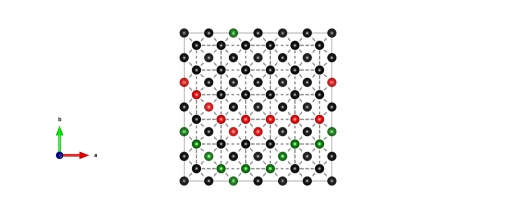

In [5]:
image = mpimg.imread('data/graph_percolation.png')
plt.imshow(image)
plt.axis('off')
plt.show()

To visually understand the graph analysis part, consider the following example:

Dotted lines represent possible jumps, but a solid edge is drawn only if the environment-specific activation energy is below the energy cutoff. Assume that colored nodes are connected while black nodes are not. In this case, a green path would be considered percolating as it spans one direction of the supercell and the endpoint is an image of the start point. The red path, however, would not be considered percolating as the endpoint does not match the image of the starting site.

Now let's perform the analysis.

In [ ]:
# Save activation energy per environment from AIMD as a dictionary.
env_e_act_dict = dict(zip(zip(filtered_env_data['jump_type'], filtered_env_data['environment']), filtered_env_data['e_act']))

# Run the percolation analysis steps 2-6.
# The function returns the fraction of connected sites and the probability of connection.
fraction_of_connected_sites, probability_of_connection = analyse_percolation_through_one_supercell(
    random_structure_li, # Structure with lithium sites
    random_structure_env, # Structure with random distribution of anion environment
    env_e_act_dict,  # Dictionary mapping jump types & environments to activation energies.
    0.45,             # Activation energy cutoff (eV)
    one_to_zero,      # Periodicity mapping from add_periodic_images
    iterations=1      # Number of iterations (for statistical analysis)
)
print(f'\n Fraction of connected lithium sites: {fraction_of_connected_sites[0]:.2f} '
      f'and probability of connection: {probability_of_connection[0]:.2f}')

The code output some errors; this is normal for our example. It happens if some of the environments are absent in the AIMD jump library.

**Note:** For a given supercell and a given energy cutoff, the analysis needs to be repeated until the average fraction of sites in the percolation network converges.

##### 7. Plotting the Percolation Diagram

Here, we load precomputed percolation results from pickled files and plot the percentage of Li sites in the percolation network as a function of the jump activation energy cutoff.

In [ ]:
import pickle as pkl

with open('data/percolation_results.pkl', 'rb') as h:
  d = pkl.load(h)

# Extract x (cutoff) and y (average fraction of Li sites) data.
x = np.array(list(d.keys()))
y = np.array([d[i]['average_fraction_of_Li'] for i in x])
y_error = np.array([d[i]['average_fraction_error'] for i in x])
x_error = np.array([0.02 for i in x])

# Plot the percolation diagram.
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(x, y, marker='', linestyle='-', color='blue', label='Data')
ax.fill_betweenx(y, x - x_error, x + x_error, color='blue', alpha=0.5, label='Error Bars')
ax.fill_between(x, y - y_error, y + y_error, color='blue', alpha=0.5, label='Error Bars')
ax.set_xticks([0.30, 0.35, 0.40, 0.45, 0.5, 0.55])
ax.set_xlabel('Jump-Ea energy cutoff (eV)')
ax.set_ylabel('Li-sites in percolation network (%)')
plt.show()

##### 8. Energy Path Analysis

In this section, we compute the free energy landscape from the simulation data, identify peaks, and find the best percolating path through the system. This involves:

* Converting the trajectory data into a density volume.
* Calculating the free energy based on the density.
* Searching for an optimal percolating path.

**8.1 Compute Free Energy Volume & Identify Peaks**

The next step is to generate the free energy graph. This uses the density volume, where every grid point (voxel) becomes a node in the graph.

Resolution is the minimum size of the voxels in Ångstrom.

Notice that there are points where it is numerically impossible to find mobile atoms. In such points the free energy is infinite and it can cause numerical instabilities.

In [ ]:
from gemdat import Trajectory

# Reload the trajectory (if needed) and filter for the diffusing specie.
VASPRUN = 'data/vasprun.xml'
trajectory = Trajectory.from_vasprun(VASPRUN, cache='data/vasprun_LSN.xml.a45e320a.cache')
diff_trajectory = trajectory.filter('Li')

# Convert the trajectory into a density volume.
volume = diff_trajectory.to_volume(resolution=0.5)

# Compute free energy from the density volume at the simulation temperature.
free_energy = volume.get_free_energy(temperature=trajectory.metadata['temperature'])

# Identify peaks in the density volume.
peaks = volume.find_peaks()

# Find the best percolating path given the peaks and desired percolation directions.
best_path = free_energy.optimal_percolating_path(peaks=peaks, percolate='xyz')
print(best_path)

Plot the best percolating path.

In [ ]:
# Create lithium structure
from pymatgen.core import Structure, Lattice
sites_li = Structure.from_spacegroup(
    sg='Fm-3m',
    lattice=Lattice.cubic(5.578),
    species=['Li', 'Li'],
    coords=[[0, 0.5, 0], [0.25, 0.25, 0.25]],
    labels=['Li-oct','Li-tet'])
sites_li.make_supercell((2,2,2))

# Plot the 3D percolation path overlaid on the Li structure.
fig1 = volume.plot_3d(paths=best_path, structure=sites_li)
fig1.show()

# Plot the energy profile along the percolation path.
fig2 = best_path.plot_energy_along_path(structure=sites_li)
fig2.show()

##### 9. Optimal Path Between Two Sites
This section shows how to compute the optimal path between two predefined sites using various pathfinding algorithms.

**9.1 Prepare Data and Define Start/Stop Points**

##### Define path

Select a start and an end point for the path.

For this example, we select two peaks of the density volume. The volume is converted into a pymatgen structure to simplify the selection of peaks. Any integer voxel coordinate (`start_point`, `stop_point`) can be used to define the path.

In [ ]:
# Convert the free energy volume to a structure for easier peak selection.
peaks = volume.to_structure()

# Choose two peaks as start and stop sites.
start_site = peaks[0]
stop_site = peaks[8]

print(start_site, '->', stop_site)

# Map the chosen sites to voxel coordinates.
start_point = volume.site_to_voxel(start_site)
stop_point = volume.site_to_voxel(stop_site)

print(start_point, '->', stop_point)

##### 0. Unweighted Path

First, we define a path as the direct (unweighted) path between the start and stop points. This result is unrealistic and has a low probability. It provides a baseline energy and shows the contrast with the energy-optimized path.

In [ ]:
# Compute the direct (unweighted) path as a baseline.
path0 = free_energy.optimal_path(
    start=start_point,
    stop=stop_point,
    method='simple',
)
print(path0)

# Plot the unweighted path in 3D along with its energy profile.
fig1 = volume.plot_3d(structure=sites_li, paths=path0)
fig1.show()

fig2 = path0.plot_energy_along_path(structure=sites_li)
fig2.show()


GEMDAT provides several algorithms:

- `simple`: Shortest, unweighted path
- `dijkstra`: Dijkstra's algorithm
- `bellman-ford`: Bellman-Ford algorithm
- `minmax-energy`: Minmax energy algorithm
- `dijkstra-exp`: Dijkstra's algorithm with exponential weights

> <div style="border: 1px solid #bce8f1; background-color: #d9edf7; padding: 10px; border-radius: 4px;">
>   <p style="margin: 0; font-weight: bold;">Task for You:</p>
>   <p>Compute and visualize the optimal path using different methods.</p>
> </div>

##### Comparison

As a final comparison, plot the energy of the paths identified with the different algorithms.

Notice from the figure above that `dijkstra`, `dijkstra-exp`, and `bellman-ford` identify the same path, while `minmax-energy` is able to find a path with a lower highest barrier, though it may be slightly longer.

In [ ]:
# Compute paths using different algorithms.
path1 = free_energy.optimal_path(start=start_point, stop=stop_point, method='dijkstra')
path2 = free_energy.optimal_path(start=start_point, stop=stop_point, method='bellman-ford')
path3 = free_energy.optimal_path(start=start_point, stop=stop_point, method='minmax-energy')
path4 = free_energy.optimal_path(start=start_point, stop=stop_point, method='dijkstra-exp')

# Plot energy profiles of the different paths.
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for path, label, ls, m in (
    (path0, 'Direct', 'solid', '+'),
    (path1, 'Dijkstra', '-', 'o'),
    (path2, 'Bellman-Ford', '--', 's'),
    (path3, 'Minmax', '-.', '^'),
    (path4, 'Dijkstra-exp', ':', 'd'),
):
    axs.plot(
        path.energy,
        label=f'{label}: E={path.total_energy:.3f} eV',
        linestyle=ls,
        marker=m,
    )
axs.set_xlabel('Path steps')
axs.set_ylabel('Energy (eV)')
axs.legend()
axs.set_title(f'Energy along paths\nfrom {start_site}\nto {stop_site}')
plt.show()

##### 10. Multiple Optimal Paths Comparison

Finally, we compare multiple optimal paths between two sites. In addition to computing the best path, we specify a number of additional paths that differ by a minimum threshold (difference score).

**10.1 Define Number of Paths and Minimum Difference**

##### Define path

Select a start and an end point for the path.

For this example, we select two peaks of the density volume. The volume is converted into a pymatgen structure to simplify the selection of peaks. Any integer voxel coordinate (`start_point`, `stop_point`) can be used to define the path.

In [ ]:
peaks = volume.to_structure()

start_site = peaks[0]
stop_site = peaks[8]

print(start_site, '->', stop_site)

start_point = volume.site_to_voxel(start_site)
stop_point = volume.site_to_voxel(stop_site)

print(start_point, '->', stop_point)

Set the number of paths we are looking for.

In [ ]:
# Define the number of paths to compare.
n_paths = 3

Before proceeding, note that it is possible to have multiple small variations of the same path labeled as different paths. For this reason, we introduce a difference score:

$$\mathcal{D}(\mathcal{p}_1,\mathcal{p}_2) = \frac{\sum_{\mathrm{site}_i \in \mathcal{p}_1} [0\; \mathrm{ if }\;\mathrm{site}_i \in \mathcal{p}_2\; \mathrm{else }\;1 ] }{ \mathrm{Length}(\mathcal{p}_1) },$$

that corresponds to the percentage of sites of $\mathcal{p}_1$ that are not in $\mathcal{p}_2$.

We say that two paths are different if $\mathcal{D} > dmin$.

In [ ]:
# Define the minimum difference score (percentage of sites differing between paths).
dmin = 0.15

##### Calculate the Paths

The first path is the optimal path, and the other paths are small variations of the optimal path.

In [ ]:
# Compute the optimal path and additional paths that differ by at least dmin.
best_path, *other_paths = free_energy.optimal_n_paths(
    start=start_point,
    stop=stop_point,
    n_paths=n_paths,
    min_diff=dmin,
)
print(best_path)

# Plot the multiple paths in 3D.
fig1 = volume.plot_3d(paths=(best_path, *other_paths), structure=sites_li)
fig1.show()

# Plot the energy profiles for the best path and its variations.
fig2 = best_path.plot_energy_along_path(structure=sites_li, other_paths=other_paths)
fig2.show()